# Mixed Linear Model 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

import statsmodels.api as sm
import scipy.stats as stats

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) if '/' in c else c for c in dta.columns]

In [5]:
dta.ccg.unique().shape

(73,)

## Add random feature

In [6]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [7]:
dta.shape

(1465, 14)

## Train test split 

In [8]:
train, test = train_test_split(dta,random_state=29)

In [9]:
y_train = train['ae_attendances_attendances'].values
X_train = train.drop(['ae_attendances_attendances','ccg','month'], axis=1)

y_test = test['ae_attendances_attendances'].values
X_test = test.drop(['ae_attendances_attendances','ccg','month'], axis=1)

## Model 

### Cross-validate 

In [10]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test = [],[]

y = dta['ae_attendances_attendances']
X = dta.drop(['ae_attendances_attendances','month', 'year'], axis=1)
    
for train_index, test_index in cv.split(X, y):
    
    model = MixedLM(endog=y.iloc[train_index].values, 
                    exog = X.iloc[train_index].drop(['ccg'],axis=1).values,
                    groups=X.iloc[train_index].ccg.values)

    ml_fit = model.fit()
    
    y_pred_test = model.predict(ml_fit.fe_params, 
                                 exog=X.iloc[test_index].drop(['ccg'],axis=1).values)
    y_pred_train = model.predict(ml_fit.fe_params, 
                                  exog=X.iloc[train_index].drop(['ccg'],axis=1).values)
    
    scores_test.append(r2_score(y.iloc[test_index],y_pred_test))
    scores_train.append(r2_score(y.iloc[train_index],y_pred_train))

In [11]:
res=pd.DataFrame()
res['test_score'] = scores_test
res['train_score'] = scores_train

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.169615,0.174929
std,0.041278,0.034723
min,0.109339,0.118459
25%,0.132421,0.149794
50%,0.165817,0.181361
75%,0.198318,0.197004
max,0.249490,0.260264


### Coefficients 

In [12]:
model = MixedLM(endog=y, exog = X.drop(['ccg'],axis=1).values, 
                groups=X.ccg.values)


ml_fit = model.fit()

In [13]:
ml_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:            MixedLM Dependent Variable: ae_attendances_attendances
No. Observations: 1465    Method:             REML                      
No. Groups:       73      Scale:              1898.5082                 
Min. group size:  2       Log-Likelihood:     -7847.0631                
Max. group size:  24      Converged:          Yes                       
Mean group size:  20.1                                                  
---------------------------------------------------------------------------
                 Coef.      Std.Err.      z       P>|z|    [0.025    0.975]
---------------------------------------------------------------------------
x1                 0.277       0.057     4.872    0.000     0.166     0.388
x2                -0.306       0.068    -4.521    0.000    -0.439    -0.173
x3                -0.037       0.078    -0.472    0.637    -0.190     0.116
x4                 0.048       0.102     0.464    0.642    -0.153     0.248
x5                 0.013       0.002     5.749    0.000     0.009     0.018
x6                -1.688       0.625    -2.700    0.007    -2.913    -0.463
x7                -4.884       1.350    -3.618    0.000    -7.530    -2.238
x8                 8.657       2.808     3.083    0.002     3.153    14.161
x9                 1.407       3.073     0.458    0.647    -4.615     7.429
x10                5.976       3.960     1.509    0.131    -1.786    13.737
Group Var      62694.527     269.918                                       
========================================================================

"""

### Residuals 

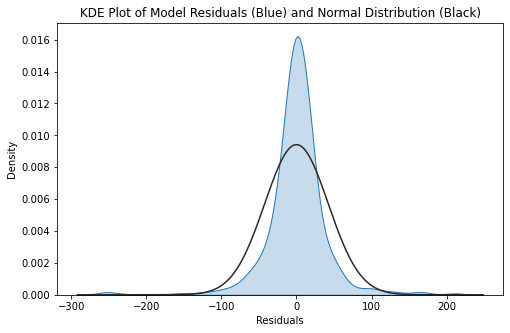

In [14]:
fig = plt.figure(figsize = (8, 5))


ax = sns.distplot(ml_fit.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")
plt.show()

### Q-Q Plot 

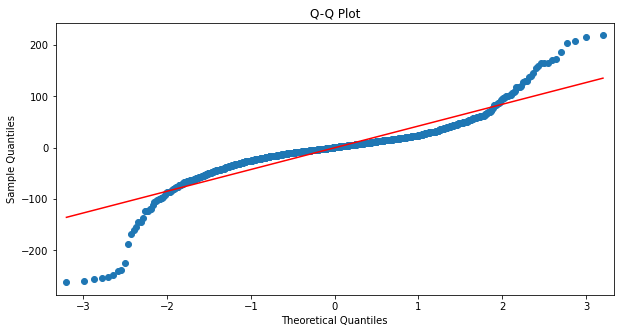

In [15]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)

sm.qqplot(ml_fit.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

plt.show()

### Residuals by CCG 

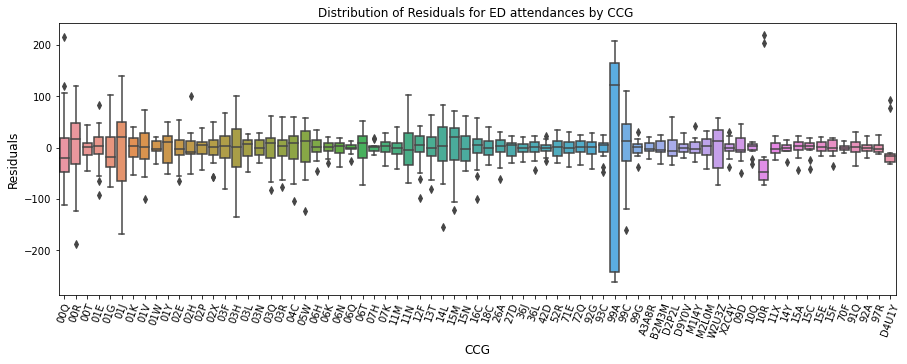

In [16]:
fig = plt.figure(figsize = (15, 5))

ax = sns.boxplot(x = ml_fit.model.groups, y = ml_fit.resid)

ax.set_title("Distribution of Residuals for ED attendances by CCG ")
ax.set_ylabel("Residuals", fontsize=12)
ax.set_xlabel("CCG", fontsize=12)
plt.xticks(rotation=70)
plt.show()